In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
card = pd.read_csv('data/card_transdata.csv')

In [16]:
card.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
card.shape

(1000000, 8)

# EDA

In [5]:
# check null values
card.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

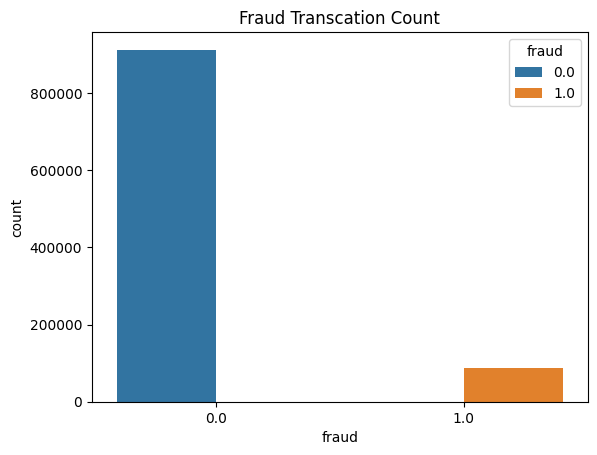

In [6]:
# Class Distribution
class_dist = card['fraud'].astype(str).value_counts().reset_index()
fig1, ax1 = plt.subplots()
ax1 = sns.barplot(
        x='fraud', 
        y='count', 
        hue='fraud',
        data=class_dist,
    )
plt.title('Fraud Transcation Count')
plt.show()

Text(0.5, 1.0, 'Correlation Plot')

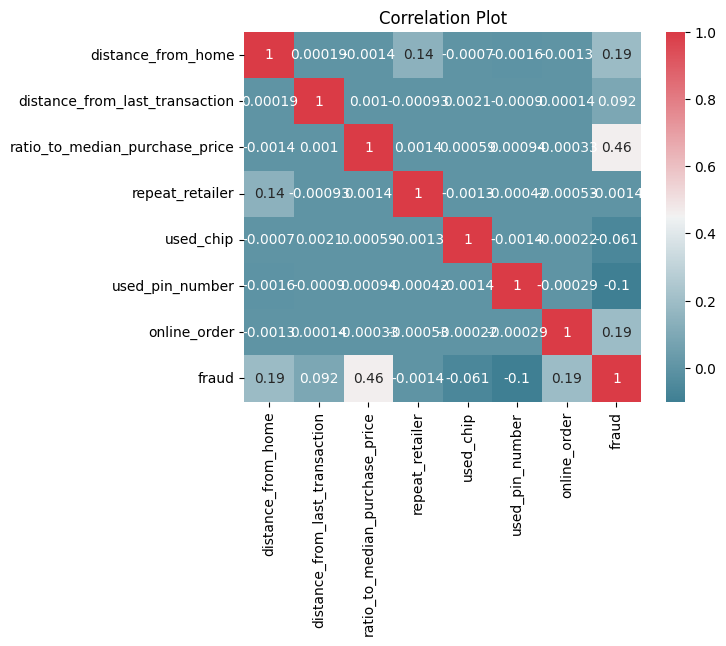

In [7]:
# correlation plot
fig2, ax2 = plt.subplots()
corr = card.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax2 = sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = cmap)
plt.title('Correlation Plot')

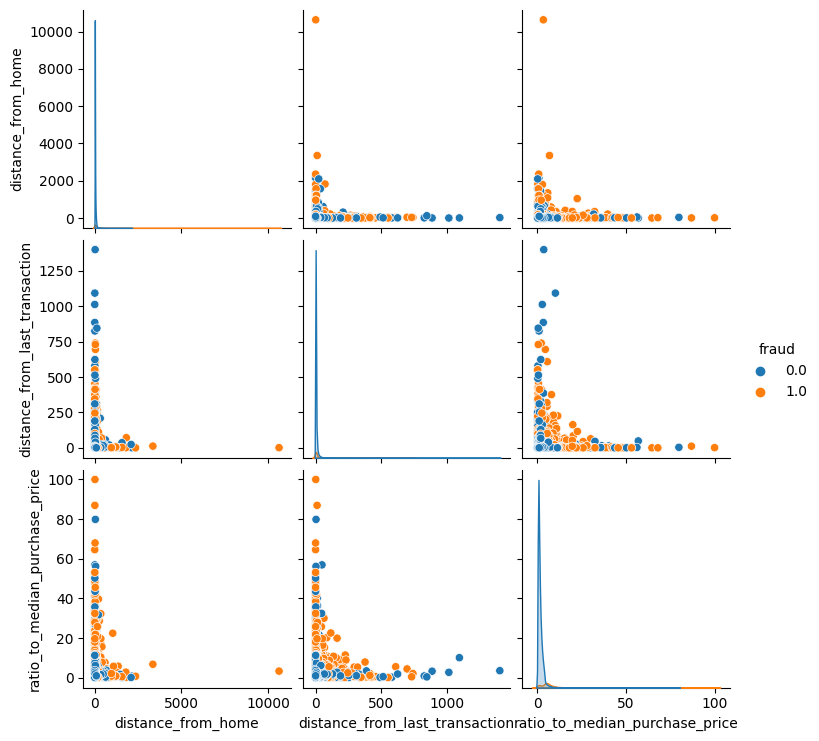

In [8]:
# Numerical features pairplot
subcard = card.sample(50000, random_state=42)
sns.pairplot(subcard[['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price','fraud']], hue ='fraud')

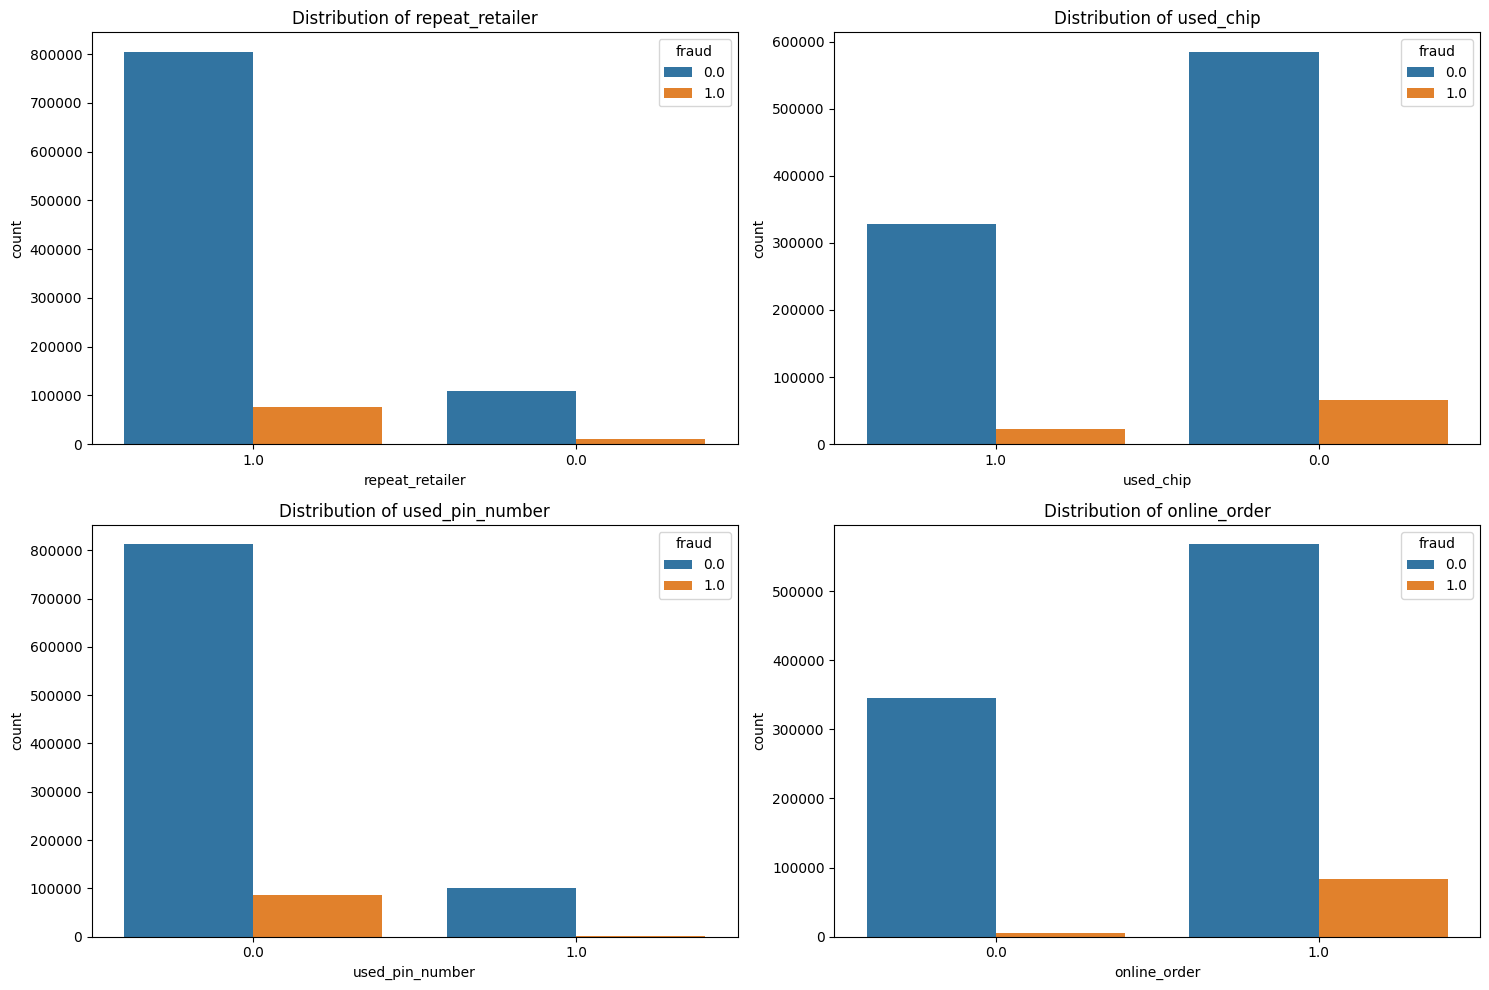

In [9]:
# Categorical features distribution
fig,axs = plt.subplots(2,2,figsize=(15,10))
for col, ax in zip(['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order'], axs.ravel()): 
    sns.countplot(x=card[col].astype(str), hue=card['fraud'], ax = ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Outlier detection

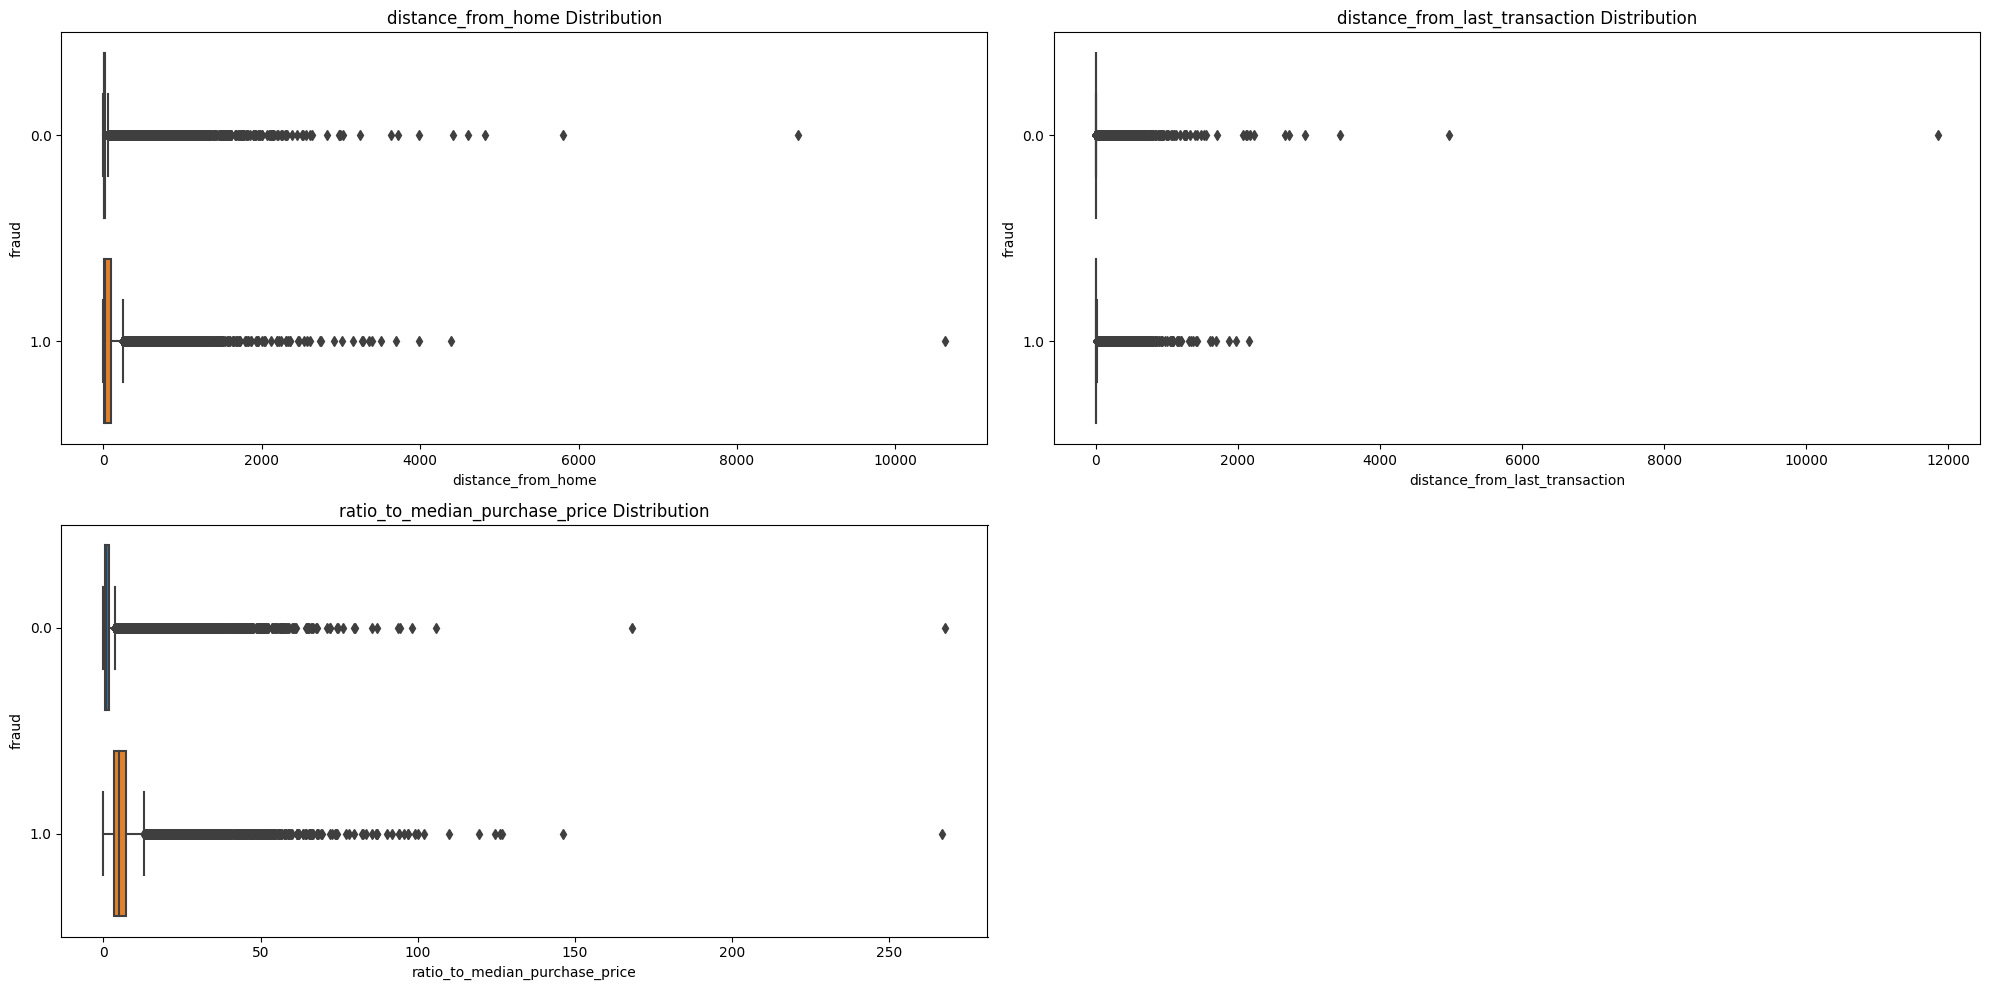

In [3]:
# Numerical features distribution: boxplot (checke outliers)
card_box = card.copy()
card_box['fraud'] = card_box['fraud'].astype(str)
fig, axs = plt.subplots(2,2,figsize=(20,10))
fig.delaxes(axs[1,1])
for col, ax in zip(['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'], axs.ravel()):
    sns.boxplot(x=col, y='fraud', data = card_box, ax = ax)
    ax.set_title(col+' Distribution')
plt.tight_layout()
plt.show()

In [4]:
# deal with outliers
## method 1: drop outliers
card_drop = card.copy()
for i in ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']:
    Q1, Q3 = np.percentile(card_drop[[i]], [25, 75])
    IQR = Q3 - Q1
    card_drop = card_drop[~((card_drop[i] < (Q1 - 1.5 * IQR)) | (card_drop[i] > (Q3 + 1.5 * IQR)))] 
card_drop.shape

(718686, 8)

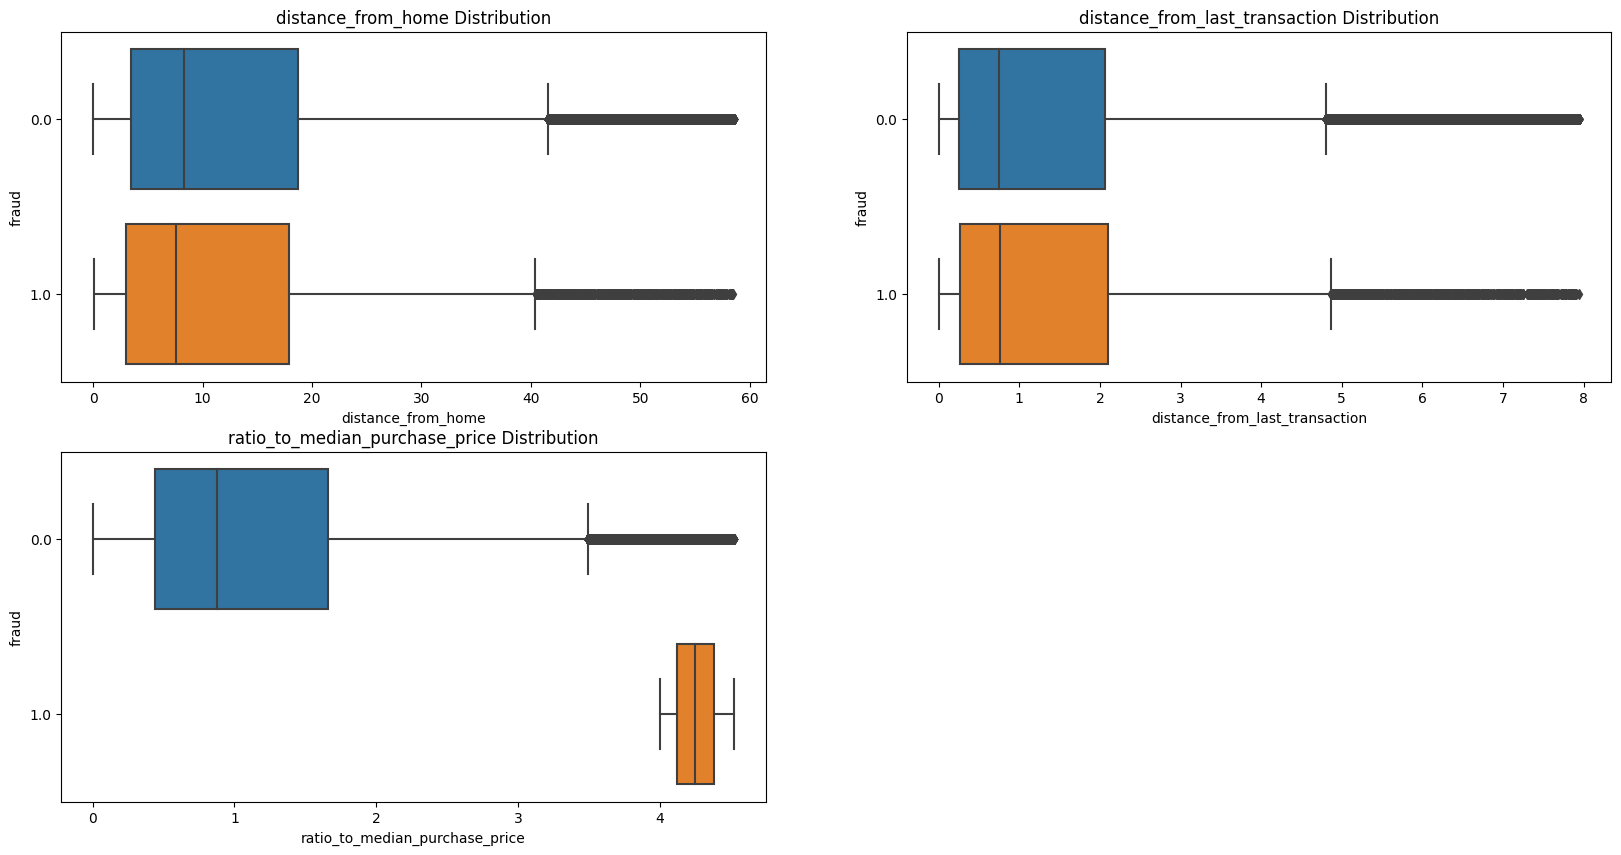

In [5]:
# Result of method 1: Distribution after removing outliers
card_box = card_drop.copy()
card_box['fraud'] = card_box['fraud'].astype(str)
fig, axs = plt.subplots(2,2,figsize=(20,10))
fig.delaxes(axs[1,1])
for col, ax in zip(['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'], axs.ravel()):
    sns.boxplot(x=col, y = 'fraud', data = card_box, ax = ax)
    ax.set_title(col+' Distribution')
plt.show()

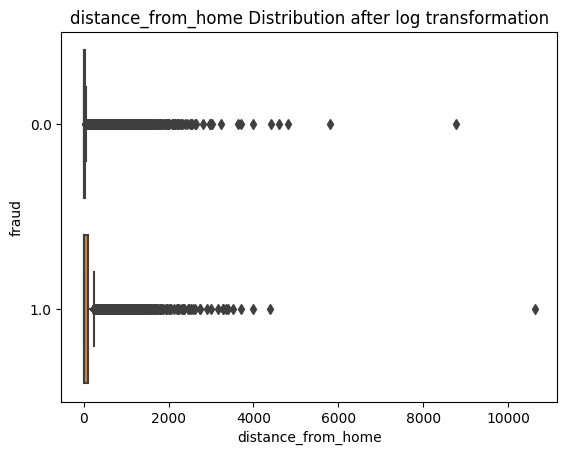

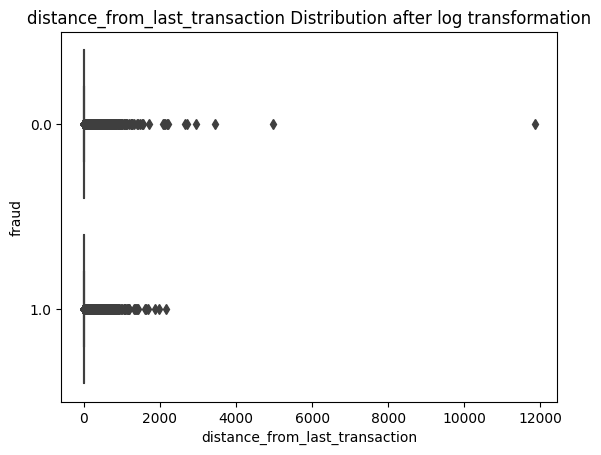

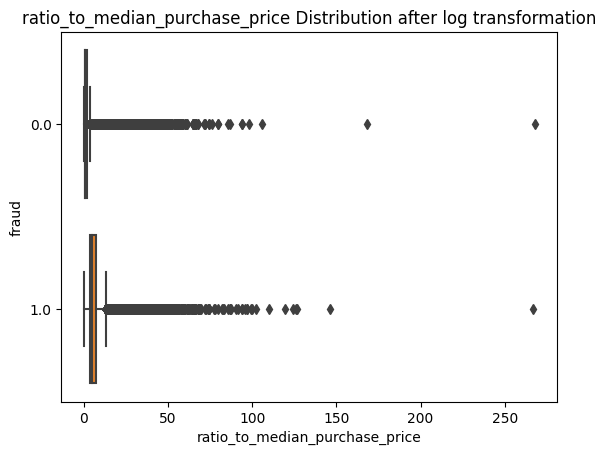

In [7]:
# Alternative test: log transformation (not used)
card_log = card.copy()
for i in ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']:
    card_log['log_'+i] = np.log(card_log[i])

card_log_box = card_log.copy()
card_log_box['fraud'] = card_log_box['fraud'].astype(str)
for col in ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']:
    sns.boxplot(x=col, y = 'fraud', data = card_log_box)
    plt.title(col+' Distribution after log transformation')
    plt.show()

# Model Selection
## Train Test Split

In [4]:
X = card.drop('fraud', axis=1)
y = card['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Standardize Data

In [5]:
scaler = StandardScaler()
col_names = ['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']
X_train[col_names] = scaler.fit_transform(X_train[col_names])

In [6]:
X_test[col_names] = scaler.transform(X_test[col_names])

## Hyperparameter Tuning and Model Comparison
### Logistic Regression

In [22]:
# Fit Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

# Model Evaluation
metrics_df = pd.DataFrame(index=['accuracy', 'f1'])
metrics_df['logistic'] = [metrics.f1_score(y_test, y_pred), metrics.accuracy_score(y_test, y_pred)]
report_log = metrics.classification_report(y_test, y_pred)  

### SVM (with hyperparameter tuning)

In [24]:
# Fit SVM
# Define the parameter grid
from sklearn.svm import SVC
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.1, 0.01, 0.001],
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'max_iter': [1000, -1]}
svm = SVC()

# Hyperparameter tuning
grid_svc = RandomizedSearchCV(svm,param_grid, n_iter = 5, cv=5, scoring='f1', n_jobs=-1, refit=True)
grid_svc.fit(X_train,y_train)
svm_model = grid_svc.best_estimator_

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_svc.best_params_)
print("Best score (f1):", grid_svc.best_score_)

# Model Evaluation
y_pred=svm_model.predict(X_test)
metrics_df['SVM'] = [metrics.f1_score(y_test, y_pred), metrics.accuracy_score(y_test, y_pred)]
report_svm = metrics.classification_report(y_test, y_pred)

/Users/mengyuwen/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mengyuwen/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mengyuwen/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mengyuwen/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mengyuwen/miniconda3/envs

Best parameters:  {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
Best score (f1) 0.4043683167879135


### Random Forest (with hyperparameter tuning)

In [25]:
# Fit Random Forest
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}
rf = RandomForestClassifier()

# Perform grid search cross-validation
grid_rf = RandomizedSearchCV(rf, param_grid, n_iter = 1, cv=5, scoring='f1', n_jobs=-1, refit=True)
grid_rf.fit(X_train, y_train)
rf_model = grid_rf.best_estimator_

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_rf.best_params_)
print("Best score (f1): ", grid_rf.best_score_)

# Model Evaluation
y_pred=rf_model.predict(X_test)
metrics_df['RF'] = [metrics.f1_score(y_test, y_pred), metrics.accuracy_score(y_test, y_pred)]
report_rf = metrics.classification_report(y_test, y_pred)

Best parameters:  {'n_estimators': 100, 'max_depth': 5}
Best score (f1):  0.9909529980723184


In [26]:
# Accuracy and F1 score comparison
metrics_df

,logistic,SVM,RF
accuracy,0.716446,0.425421,0.996462
f1,0.958645,0.797975,0.999385


In [27]:
# Classification reports comparison
print('Logistic Regression:\n')
print(report_log)
print('SVM:\n')
print(report_svm)
print('Random Forest:\n')
print(report_rf)

Logistic Regression:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    182557
         1.0       0.89      0.60      0.72     17443

    accuracy                           0.96    200000
   macro avg       0.93      0.80      0.85    200000
weighted avg       0.96      0.96      0.95    200000

SVM:

              precision    recall  f1-score   support

         0.0       0.98      0.79      0.88    182557
         1.0       0.28      0.86      0.43     17443

    accuracy                           0.80    200000
   macro avg       0.63      0.82      0.65    200000
weighted avg       0.92      0.80      0.84    200000

Random Forest:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182557
         1.0       1.00      0.99      1.00     17443

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1